# Group Fairness metrics

This notebook describes the steps for group fairness evaluation of the different OOD detectors trained on different proportions of the FST V-VI samples.
The OOD detectors (OneSVM, IF, and Autoencoder) are trained omn 3 different proportions of the FST V-vI samples from the Fitpatrick17k dataset. 

### Imports

In [ ]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from warnings import warn

from IPython.display import Markdown, display
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.explainers import MetricTextExplainer
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification

from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import classification_report

import sys
sys.path.append("../")

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


# Group Fairness Evaluation using Fitz17k with proportions as IDD and SD-198 as OOD

In this section we evaluate group Fairness metrics of the OOD detectors trained on different FST V-VI proportions from the Fitz17k dataset (11% , 8% , 5%), using the AIF360 Toolkit we evaluate the group fairness emtrics which are Statistical Parity Difference and Disparate Impact.

## 1. Oneclass SVM with Proportions

We load the dataset samples and apply preprocessing steps and train the one class SVM.

In [ ]:
from pathlib import Path
from PIL import Image


X_data = []

#Fitz17k

folder_dir = ".....Path to the Fit17k with 11% FST V-VI....."
#folder_dir_8 = ".....Path to the Fit17k with 8% FST V-VI....."
#folder_dir_5 = ".....Path to the Fit17k with 5% FST V-VI....."

images = Path(folder_dir).glob("*.png")#jpg
count = 0
for i in list(images)[:10000]:#10000
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    X_data.append(img_resize)
    count += 1

In [ ]:
ood_FST_V_VI = []
ood_FST_I_IV = []
ood_data = []
FST_V_VI_dir = "...Path to SD-198 FST V-VI..."
FST_I_IV_dir = "... Path to SD-198 FST I-IV ..."
ALL_dir = ".. Path to ALL SD-198..."

# Process images from the darker directory
FST_V_VI_images = Path(FST_V_VI_dir).glob("*.jpg")
for i in FST_V_VI_images:
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    ood_FST_V_VI.append(img_resize)
    ood_data.append(img_resize)


# Process images from the lighter directory
FST_I_IV_image = Path(FST_I_IV_dir).glob("*.jpg")
for i in list(FST_I_IV_image)[:3300]:#3300
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    ood_FST_I_IV.append(img_resize)
    ood_data.append(img_resize)

In [ ]:

X_array = np.array(X_data)
ood_array = np.array(ood_data)  #for all
ood_D_array = np.array(ood_FST_V_VI) #for darker only
ood_L_array = np.array(ood_FST_I_IV) #for lighter only

In [ ]:
len(X_data) , len(ood_data),len(ood_FST_I_IV) , len(ood_FST_V_VI)

(4132, 3510, 3300, 210)

In [ ]:
y_ind = np.zeros(X_array.shape[0])  # not an OOD sample
y_ood_D = np.ones(ood_D_array.shape[0]) *1 # an OOD sample (darker)
y_ood_L = np.ones(ood_L_array.shape[0])   # an OOD sample (lighter)
y_ood = np.ones(ood_array.shape[0])
X = np.concatenate([X_array, ood_D_array, ood_L_array])
y = np.concatenate([y_ind, y_ood_D,y_ood_L])

print(X.shape, y.shape)

(7642, 3072) (7642,)


In [ ]:
y_ood_D_ = np.ones(ood_D_array.shape[0]) *1 # an OOD sample (darker)
y_ood_L_ = np.zeros(ood_L_array.shape[0])   # an OOD sample (lighter)
y_FST=np.concatenate([y_ind,y_ood_D_,y_ood_L_])

In [ ]:
from sklearn.decomposition import PCA
import importlib

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

explained variance ratio (first two components): [0.19059085 0.12147188]


In [ ]:
from sklearn.svm import OneClassSVM
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, stratify=y,random_state=42)# ,random_state=42

onesvm = OneClassSVM(kernel="rbf", gamma=0.0001,nu=0.01)
onesvm.fit(X_train)

y_pred = onesvm.predict(X_test)

OneClassSVM(gamma=0.0001, nu=0.01)

The predictions and true labels, along with their corresponding skin tone stratification, are displayed in a dataframe to be used in the fairness metrics calculation

In [ ]:
import pandas as pd
from tabulate import tabulate

dataset_df = pd.DataFrame({'y': y_test,'FST': y_FST_test, 'Predicted': y_pred})

print(tabulate(dataset_df, headers='keys', tablefmt="mixed_outline"))

┍━━━━━━┯━━━━━┯━━━━━━━┯━━━━━━━━━━━━━┑
│      │   y │   FST │   Predicted │
┝━━━━━━┿━━━━━┿━━━━━━━┿━━━━━━━━━━━━━┥
│    0 │   0 │     0 │          -1 │
│    1 │   1 │     0 │          -1 │
│    2 │   0 │     0 │          -1 │
│    3 │   0 │     0 │           1 │
│    4 │   1 │     0 │           1 │
│    5 │   1 │     0 │          -1 │
│    6 │   1 │     0 │          -1 │
│    7 │   1 │     0 │          -1 │
│    8 │   1 │     0 │           1 │
│    9 │   0 │     0 │           1 │
│   10 │   0 │     0 │           1 │
│   11 │   1 │     0 │           1 │
│   12 │   0 │     0 │           1 │
│   13 │   0 │     0 │          -1 │
│   14 │   1 │     0 │           1 │
│   15 │   0 │     0 │          -1 │
│   16 │   0 │     0 │           1 │
│   17 │   0 │     0 │           1 │
│   18 │   1 │     0 │           1 │
│   19 │   0 │     0 │          -1 │
│   20 │   0 │     0 │          -1 │
│   21 │   1 │     0 │          -1 │
│   22 │   0 │     0 │          -1 │
│   23 │   0 │     0 │           1 │
│

In [ ]:
#add y_pred column to the dataset which shows the labeled

dataset_df['Predicted'].replace({1: 0, -1: 1}, inplace=True)
print(tabulate(dataset_df, headers='keys', tablefmt="mixed_outline"))

┍━━━━━━┯━━━━━┯━━━━━━━┯━━━━━━━━━━━━━┑
│      │   y │   FST │   Predicted │
┝━━━━━━┿━━━━━┿━━━━━━━┿━━━━━━━━━━━━━┥
│    0 │   0 │     0 │           1 │
│    1 │   1 │     0 │           1 │
│    2 │   0 │     0 │           1 │
│    3 │   0 │     0 │           0 │
│    4 │   1 │     0 │           0 │
│    5 │   1 │     0 │           1 │
│    6 │   1 │     0 │           1 │
│    7 │   1 │     0 │           1 │
│    8 │   1 │     0 │           0 │
│    9 │   0 │     0 │           0 │
│   10 │   0 │     0 │           0 │
│   11 │   1 │     0 │           0 │
│   12 │   0 │     0 │           0 │
│   13 │   0 │     0 │           1 │
│   14 │   1 │     0 │           0 │
│   15 │   0 │     0 │           1 │
│   16 │   0 │     0 │           0 │
│   17 │   0 │     0 │           0 │
│   18 │   1 │     0 │           0 │
│   19 │   0 │     0 │           1 │
│   20 │   0 │     0 │           1 │
│   21 │   1 │     0 │           1 │
│   22 │   0 │     0 │           1 │
│   23 │   0 │     0 │           0 │
│

In [ ]:
print(dataset_df)

# Check the data types of columns
print(dataset_df.dtypes)

        y  FST  Predicted
0     0.0  0.0          1
1     1.0  0.0          1
2     0.0  0.0          1
3     0.0  0.0          0
4     1.0  0.0          0
...   ...  ...        ...
3052  0.0  0.0          0
3053  1.0  0.0          1
3054  1.0  0.0          1
3055  1.0  0.0          0
3056  0.0  0.0          0

[3057 rows x 3 columns]
y            float64
FST          float64
Predicted      int64
dtype: object


In [ ]:
print(dataset_df.columns)

Index(['y', 'FST', 'Predicted'], dtype='object')


The previliged (advantaged) and the unpreviliged (disadvantaged) groups and the favorable and unfavorable labels are identified 

In [ ]:
p = [{'FST': 0}]   #previliged group FST I_IV
u = [{'FST': 1}]   #unpreviliged group FST V-VI
favorable_label = 1   #OOD 
unfavorable_label = 0   #ID

Using the AIF360 toolkit we identify the binary dataset to be used in group fairness metrics calculation 

In [ ]:
from aif360.datasets import BinaryLabelDataset

# Create AIF360 dataset
dataset_aif360 = BinaryLabelDataset(df=dataset_df, label_names=['Predicted'], protected_attribute_names=['FST'])


We evaluate the group fairness metrics for each proportion:

Fitz 11%

In [3]:
# Create metrics using y_pred
metric_dataset = BinaryLabelDatasetMetric(dataset_aif360, unprivileged_groups= u , privileged_groups= p)
classified_metric = ClassificationMetric(dataset_aif360, dataset_aif360, unprivileged_groups= u, privileged_groups= p)

# Calculate fairness metrics
print("Statistical Parity Difference (SPD):", metric_dataset.statistical_parity_difference())
print("Disparate Impact (DI):", classified_metric.disparate_impact())

Statistical Parity Difference (SPD): -0.06967418546365911
Disparate Impact (DI): 0.8634242200933432


Fitz 8%

In [2]:
metric_dataset = BinaryLabelDatasetMetric(dataset_aif360, unprivileged_groups= u , privileged_groups= p)
classified_metric = ClassificationMetric(dataset_aif360, dataset_aif360, unprivileged_groups= u, privileged_groups= p)

# Calculate fairness metrics
print("Statistical Parity Difference (SPD):", metric_dataset.statistical_parity_difference())
print("Disparate Impact (DI):", classified_metric.disparate_impact())

Statistical Parity Difference (SPD): 0.033521303258145396
Disparate Impact (DI): 1.0652041438147473


Fitz 5%

In [1]:
metric_dataset = BinaryLabelDatasetMetric(dataset_aif360, unprivileged_groups= u , privileged_groups= p)
classified_metric = ClassificationMetric(dataset_aif360, dataset_aif360, unprivileged_groups= u, privileged_groups= p)

# Calculate fairness metrics
print("Statistical Parity Difference (SPD):", metric_dataset.statistical_parity_difference())
print("Disparate Impact (DI):", classified_metric.disparate_impact())

Statistical Parity Difference (SPD): 0.00971177944862156
Disparate Impact (DI): 1.0188909201706278


## 2. Isolation Forest

We follow the same process for IF group fairness evaluation, by training the Isolation forest and defining the previliged and the unpreviliged groups and favorable and unfavorable labels

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, stratify=y) #, random_state=42
best_clf = IsolationForest(n_estimators=100, contamination=0.1, bootstrap=False,  max_samples=110,random_state=42)
best_clf.fit(X_train)
y_pred = best_clf.predict(X_test)
X_train, X_test, y_FST_train, y_FST_test = train_test_split(X_pca, y_FST, test_size=0.4, stratify=y_FST)# ,random_state=42

IsolationForest(contamination=0.1, max_samples=110, random_state=42)

In [ ]:
import pandas as pd
from tabulate import tabulate

dataset_df = pd.DataFrame({'y': y_test,'FST': y_FST_test, 'Predicted': y_pred})
print(tabulate(dataset_df, headers='keys', tablefmt="mixed_outline"))

┍━━━━━━┯━━━━━┯━━━━━━━┯━━━━━━━━━━━━━┑
│      │   y │   FST │   Predicted │
┝━━━━━━┿━━━━━┿━━━━━━━┿━━━━━━━━━━━━━┥
│    0 │   1 │     0 │          -1 │
│    1 │   1 │     0 │           1 │
│    2 │   0 │     0 │           1 │
│    3 │   1 │     0 │           1 │
│    4 │   0 │     0 │           1 │
│    5 │   0 │     0 │           1 │
│    6 │   1 │     0 │          -1 │
│    7 │   0 │     0 │           1 │
│    8 │   1 │     0 │           1 │
│    9 │   0 │     0 │           1 │
│   10 │   1 │     0 │           1 │
│   11 │   1 │     0 │           1 │
│   12 │   0 │     0 │           1 │
│   13 │   0 │     0 │           1 │
│   14 │   0 │     0 │           1 │
│   15 │   1 │     0 │          -1 │
│   16 │   1 │     0 │           1 │
│   17 │   0 │     0 │           1 │
│   18 │   1 │     0 │           1 │
│   19 │   1 │     0 │           1 │
│   20 │   1 │     0 │           1 │
│   21 │   1 │     0 │           1 │
│   22 │   1 │     0 │           1 │
│   23 │   1 │     0 │           1 │
│

In [ ]:
dataset_df['Predicted'].replace({1: 0, -1: 1}, inplace=True)
print(tabulate(dataset_df, headers='keys', tablefmt="mixed_outline"))

┍━━━━━━┯━━━━━┯━━━━━━━┯━━━━━━━━━━━━━┑
│      │   y │   FST │   Predicted │
┝━━━━━━┿━━━━━┿━━━━━━━┿━━━━━━━━━━━━━┥
│    0 │   1 │     0 │           1 │
│    1 │   1 │     0 │           0 │
│    2 │   0 │     0 │           0 │
│    3 │   1 │     0 │           0 │
│    4 │   0 │     0 │           0 │
│    5 │   0 │     0 │           0 │
│    6 │   1 │     0 │           1 │
│    7 │   0 │     0 │           0 │
│    8 │   1 │     0 │           0 │
│    9 │   0 │     0 │           0 │
│   10 │   1 │     0 │           0 │
│   11 │   1 │     0 │           0 │
│   12 │   0 │     0 │           0 │
│   13 │   0 │     0 │           0 │
│   14 │   0 │     0 │           0 │
│   15 │   1 │     0 │           1 │
│   16 │   1 │     0 │           0 │
│   17 │   0 │     0 │           0 │
│   18 │   1 │     0 │           0 │
│   19 │   1 │     0 │           0 │
│   20 │   1 │     0 │           0 │
│   21 │   1 │     0 │           0 │
│   22 │   1 │     0 │           0 │
│   23 │   1 │     0 │           0 │
│

In [ ]:
print(dataset_df)

# Check the data types of columns
print(dataset_df.dtypes)

        y  FST  Predicted
0     1.0  0.0          1
1     1.0  0.0          0
2     0.0  0.0          0
3     1.0  0.0          0
4     0.0  0.0          0
...   ...  ...        ...
3052  0.0  0.0          0
3053  0.0  0.0          0
3054  0.0  0.0          0
3055  1.0  0.0          0
3056  0.0  0.0          0

[3057 rows x 3 columns]
y            float64
FST          float64
Predicted      int64
dtype: object


In [ ]:
from aif360.datasets import BinaryLabelDataset
# Create AIF360 dataset
dataset_aif360 = BinaryLabelDataset(df=dataset_df, label_names=['Predicted'], protected_attribute_names=['FST'])


In [ ]:
p = [{'FST': 0}]   #previliged group
u = [{'FST': 1}]   #unpreviliged group
favorable_label = 1
unfavorable_label = 0

The group fairness metrics are evaluated on different Fitz17k FST V-VI proportions

Fitz 11%

In [4]:
# Create metrics using y_pred
metric_dataset = BinaryLabelDatasetMetric(dataset_aif360, unprivileged_groups= u , privileged_groups= p)
classified_metric = ClassificationMetric(dataset_aif360, dataset_aif360, unprivileged_groups= u, privileged_groups= p)

# Calculate fairness metrics
print("Statistical Parity Difference (SPD):", metric_dataset.statistical_parity_difference())
print("Conditional Demographic Disparity (CDD):", classified_metric.disparate_impact())

Statistical Parity Difference (SPD): 0.26766917293233083
Disparate Impact (DI): 3.991596638655462


Fitz 8%

In [5]:
# Create metrics using y_pred
metric_dataset = BinaryLabelDatasetMetric(dataset_aif360, unprivileged_groups= u , privileged_groups= p)
classified_metric = ClassificationMetric(dataset_aif360, dataset_aif360, unprivileged_groups= u, privileged_groups= p)

# Calculate fairness metrics
print("Statistical Parity Difference (SPD):", metric_dataset.statistical_parity_difference())
print("Conditional Demographic Disparity (CDD):", classified_metric.disparate_impact())

Statistical Parity Difference (SPD): 0.2287593984962406
Disparate Impact (DI): 3.4685598377281948


Fitz 5%

In [6]:
# Create metrics using y_pred
metric_dataset = BinaryLabelDatasetMetric(dataset_aif360, unprivileged_groups= u , privileged_groups= p)
classified_metric = ClassificationMetric(dataset_aif360, dataset_aif360, unprivileged_groups= u, privileged_groups= p)

# Calculate fairness metrics
print("Statistical Parity Difference (SPD):", metric_dataset.statistical_parity_difference())
print("Conditional Demographic Disparity (CDD):", classified_metric.disparate_impact())

Statistical Parity Difference (SPD): 0.3073934837092732
Disparate Impact (DI): 4.157014157014157


## 3. AutoEncoder

the training weights of the Autoencoder on the Fitz17k of different proportions (11%,)

In [ ]:
from ae import Autoencoder
ae = Autoencoder()
ae.load_state_dict(torch.load("autoencoder_11Fitz.pkl", map_location="cpu"))
#ae.load_state_dict(torch.load("autoencoder_8Fitz.pkl", map_location="cpu"))
#ae.load_state_dict(torch.load("autoencoder_5Fitz.pkl", map_location="cpu"))

<All keys matched successfully>

In [ ]:
# Load test data for train
mse_test_FST_I_IV = np.load("mse_train.npy").tolist()
labels_test_I_IV = np.load("labels_train.npy").tolist()

# Load test data for FST I-IV
mse_test_FST_I_IV = np.load("mse_test_FST_I_IV.npy").tolist()
labels_test_I_IV = np.load("labels_test_FST_I_IV.npy").tolist()
#reconstructed_inputs_test_light = np.load("reconstructed_inputs_test_light.npy").tolist()

# Load test data for FST V-VI
mse_test_FST_V_VI = np.load("mse_test_FST_V_VI.npy").tolist()
labels_test_FSTV_VI = np.load("labels_test_FST_V_VI.npy").tolist()

In [ ]:
assert len(labels_test_FST_V_VI) == len(mse_test_FST_V_VI)
assert len(labels_test_FST_I_IV) == len(mse_test_FST_I_IV)
assert len(labels_train) == len(mse_train)

In [ ]:
print(len(labels_test_FST_V_VI))
print(len(labels_test_FST_I_IV))
print(len(labels_train))

210
6214
3305


In [ ]:
error_df_FST_V_VI = pd.DataFrame({"re": mse_test_FST_V_VI, "y_FST": labels_test_FST_V_VI})
error_df_FST_I_IV = pd.DataFrame({"re": mse_test_FST_I_IV, "y_FST": labels_test_FST_I_IV})
error_df_train = pd.DataFrame({"re": mse_train, "y_FST": labels_train})

In [ ]:
error_df_FST_V_VI["y_FST"] = 1  # Assign label 2 to FST V-VI
error_df_FST_I_IV["y_FST"] = 0  # Assign label 1 to FST I-IV
error_df_train["y_FST"] = 0  # Assign label 0 , most of the training data is FST I-IV

error_df_FST_V_VI["y"] = 1  #  dark  ood
error_df_FST_I_IV["y"] = 1  # light   ood
error_df_train["y"] = 0  # inlier

# Concatenate the DataFrames into one
error_df = pd.concat([error_df_train, error_df_FST_I_IV, error_df_FST_V_VI], ignore_index=True)
error_df= error_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
error_df

,re,y_FST,y
0,0.000000,0,0
1,37.445087,0,1
2,42.459217,0,1
3,0.000000,0,0
4,34.317390,0,1
...,...,...,...
9724,33.222610,0,1
9725,45.009041,0,1
9726,18.202398,0,1
9727,0.000000,0,0


In [ ]:
#The dummy theshold
idxs_L = 15
idxs_D = 17

In [ ]:
threshold_fixed_L = idxs_L
threshold_fixed_D = idxs_D

def apply_threshold(x):
    if (x <= threshold_fixed_L) & (x <= threshold_fixed_D):
        return 0
    else:
        return 1


#error_df["output"] = error_df["re"].apply(lambda x: 0 if x <= threshold_fixed else 1)
error_df['output'] = error_df['re'].apply(apply_threshold)  #output is the prediction results

error_df

,re,y_FST,y,output
0,0.000000,0,0,0
1,37.445087,0,1,1
2,42.459217,0,1,1
3,0.000000,0,0,0
4,34.317390,0,1,1
...,...,...,...,...
9724,33.222610,0,1,1
9725,45.009041,0,1,1
9726,18.202398,0,1,1
9727,0.000000,0,0,0


In [ ]:
from aif360.datasets import BinaryLabelDataset

# Create AIF360 dataset
dataset_aif360 = BinaryLabelDataset(df=error_df, label_names=['output'], protected_attribute_names=['y_FST'])


we define the previliged and the unpreviliged groups and the favorable and unfavorable labels

In [ ]:
p = [{'y_FST': 0}]   #previliged group
u = [{'y_FST': 1}]   #unpreviliged group
favorable_label = 1
unfavorable_label = 0

The group fairness metrics Statistical Parity Difference (SPD), Disparate Impact (DI) are calculated for each Fitz17k proportion: 

Fitz 11%

In [7]:
# Create metrics
metric_dataset = BinaryLabelDatasetMetric(dataset_aif360, unprivileged_groups= u , privileged_groups= p)
classified_metric = ClassificationMetric(dataset_aif360, dataset_aif360, unprivileged_groups= u, privileged_groups= p)

# Calculate fairness metrics
print("Statistical Parity Difference (SPD):", metric_dataset.statistical_parity_difference())
print("Disparate impact (DI):", classified_metric.disparate_impact())

Statistical Parity Difference (SPD): 0.4770623952163568
Disparate impact (DI): 1.9291966823270112


Fitz 8%

In [ ]:
# Create metrics
metric_dataset = BinaryLabelDatasetMetric(dataset_aif360, unprivileged_groups= u , privileged_groups= p)
classified_metric = ClassificationMetric(dataset_aif360, dataset_aif360, unprivileged_groups= u, privileged_groups= p)

# Calculate fairness metrics
print("Statistical Parity Difference (SPD):", metric_dataset.statistical_parity_difference())
print("Disparate impact (DI):", classified_metric.disparate_impact())

Statistical Parity Difference (SPD): 0.4645272164836556
Conditional Demographic Disparity (CDD): 1.9164055529781234


In [8]:
# Create metrics
metric_dataset = BinaryLabelDatasetMetric(dataset_aif360, unprivileged_groups= u , privileged_groups= p)
classified_metric = ClassificationMetric(dataset_aif360, dataset_aif360, unprivileged_groups= u, privileged_groups= p)

# Calculate fairness metrics
print("Statistical Parity Difference (SPD):", metric_dataset.statistical_parity_difference())
print("Disparate impact (DI):", classified_metric.disparate_impact())

Statistical Parity Difference (SPD): 0.4645272164836556
Disparate impact (DI): 1.9164055529781234


Fitz 5%

In [9]:
# Create metrics
metric_dataset = BinaryLabelDatasetMetric(dataset_aif360, unprivileged_groups= u , privileged_groups= p)
classified_metric = ClassificationMetric(dataset_aif360, dataset_aif360, unprivileged_groups= u, privileged_groups= p)

# Calculate fairness metrics
print("Statistical Parity Difference (SPD):", metric_dataset.statistical_parity_difference())
print("Disparate impact (DI):", classified_metric.disparate_impact())

Statistical Parity Difference (SPD): 0.34187333280511323
Disparate impact (DI): 1.5513806506575796


# Plotting the Correlations


We are interested to see the coorrelation between the group fairness metrics SPD and DI and the Representation Gap RG across all the Fitz17k proportions

In [ ]:
data_11 = {
    'Model' : ['One_SVM','Isolation_Forest','Auto_Encoder'],
    'SPD' : [-0.069,0.267,0.477],
    'DI': [0.863,3.991,1.929],
    'RG': [0.11,0.1,0.039]
}


df_11= pd.DataFrame(data_11)
df_11



,Model,SPD,DI,RG
0,One_SVM,-0.069,0.863,0.110
1,Isolation_Forest,0.267,3.991,0.100
2,Auto_Encoder,0.477,1.929,0.039


In [ ]:
data_8 = {
    'Model' : ['One_SVM','Isolation_Forest','Auto_Encoder'],
    'SPD' : [0.033 ,0.228,0.464],
    'DI': [1.065,3.468,1.916],
    'RG': [0.12,0.1,0.08]
}


df8= pd.DataFrame(data_8)
df8

,Model,SPD,DI,RG
0,One_SVM,0.033,1.065,0.12
1,Isolation_Forest,0.228,3.468,0.10
2,Auto_Encoder,0.464,1.916,0.08


In [ ]:
data_5 = {
    'Model' : ['One_SVM','Isolation_Forest','Auto_Encoder'],
    'SPD' : [0.009 ,0.307,0.341],
    'DI': [ 1.018,4.157,1.551],
    'RG': [0.12,0.1,0.06]
}


df5= pd.DataFrame(data_5)
df5

,Model,SPD,DI,RG
0,One_SVM,0.009,1.018,0.12
1,Isolation_Forest,0.307,4.157,0.10
2,Auto_Encoder,0.341,1.551,0.06


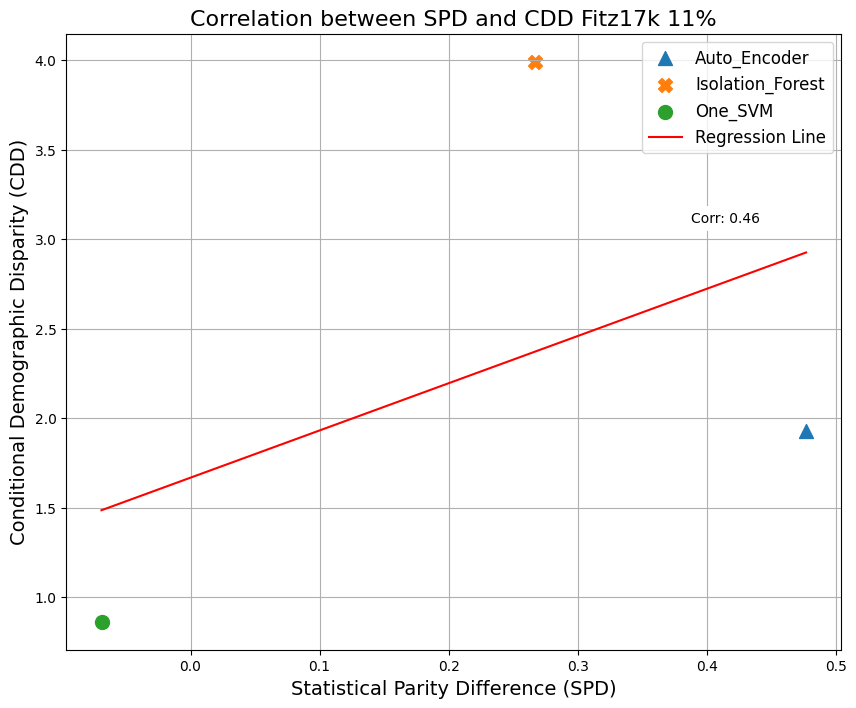

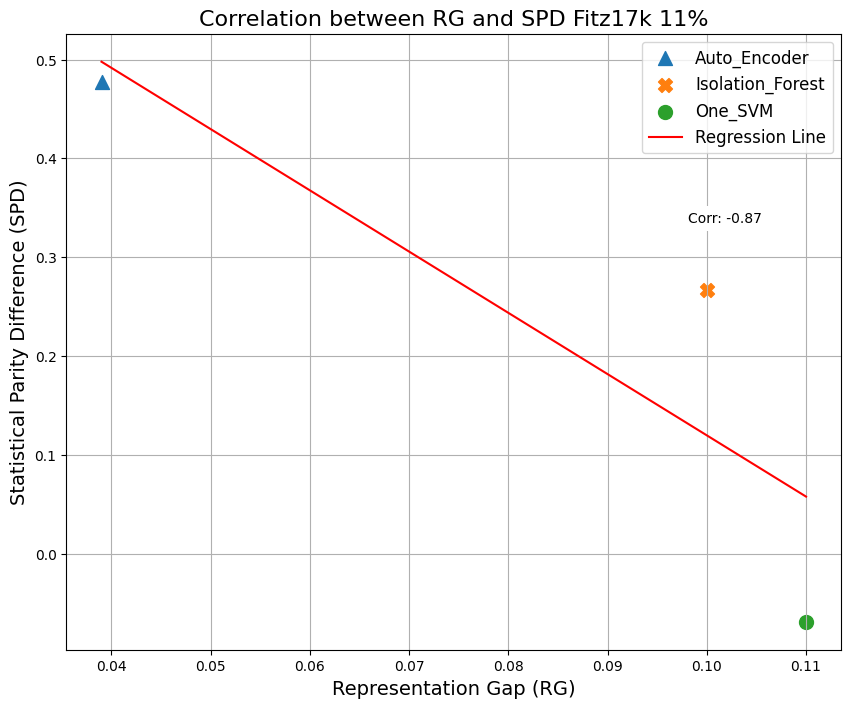

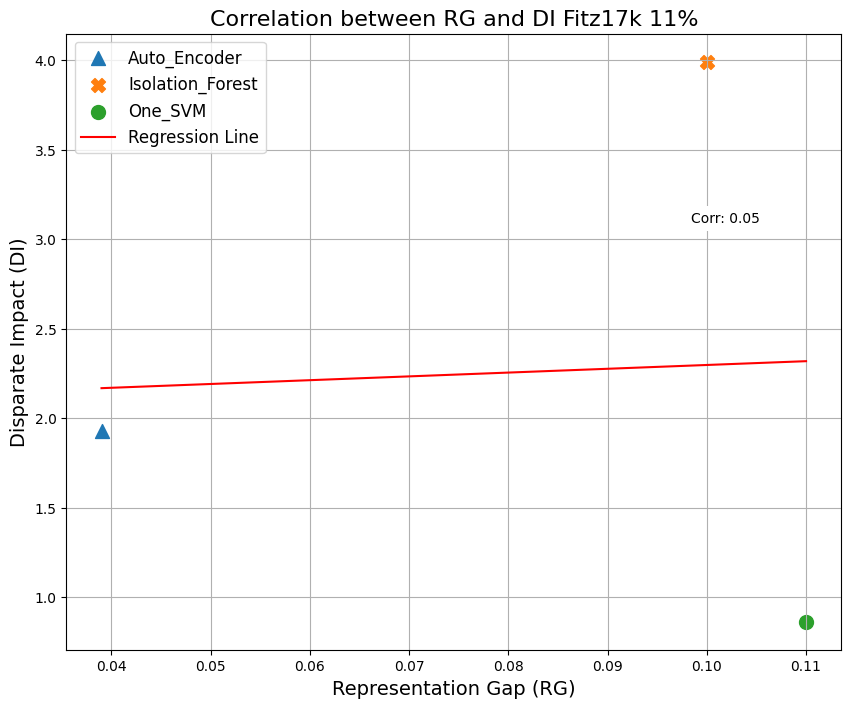

In [ ]:
from aux_group_fairness import Scatter_Plot
# Extract data for plotting
x = df_11['SPD'].values
y = df_11['DI'].values
labels = df_11['Model'].values
p='11'

Scatter_Plot(df_11['SPD'], df_11['DI'],labels,x_label='Statistical Parity Difference'  ,y_label='Disparate Impact',X='SPD',Y='CDD',P=p)
Scatter_Plot(df_11['RG'], df_11['SPD'],labels,x_label='Representation Gap',y_label='Statistical Parity Difference',X='RG',Y='SPD',P=p)
Scatter_Plot(df_11['RG'], df_11['DI'],labels,x_label='Representation Gap',y_label='Disparate Impact',X='RG',Y='DI',P=p)

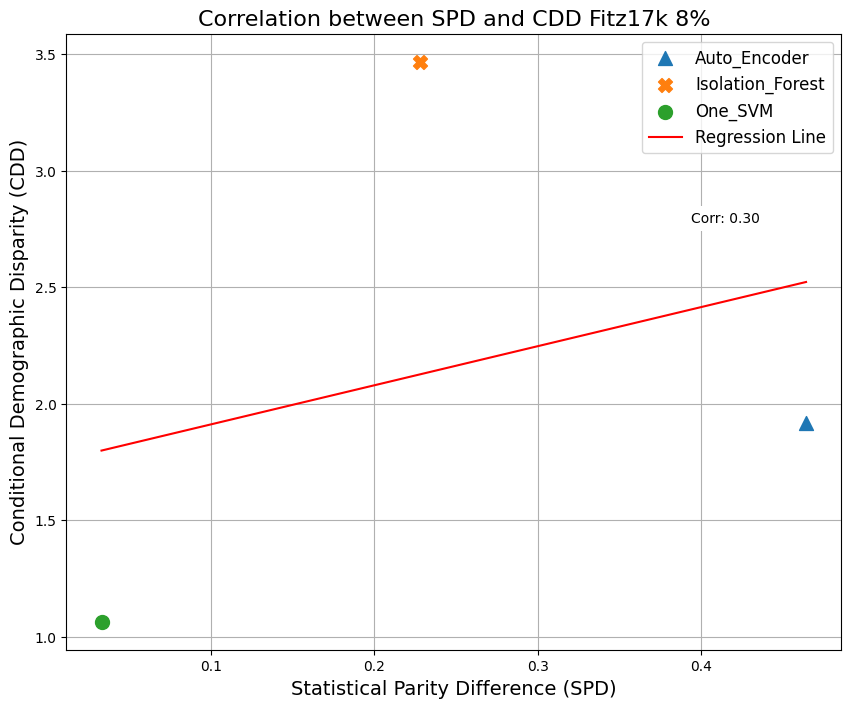

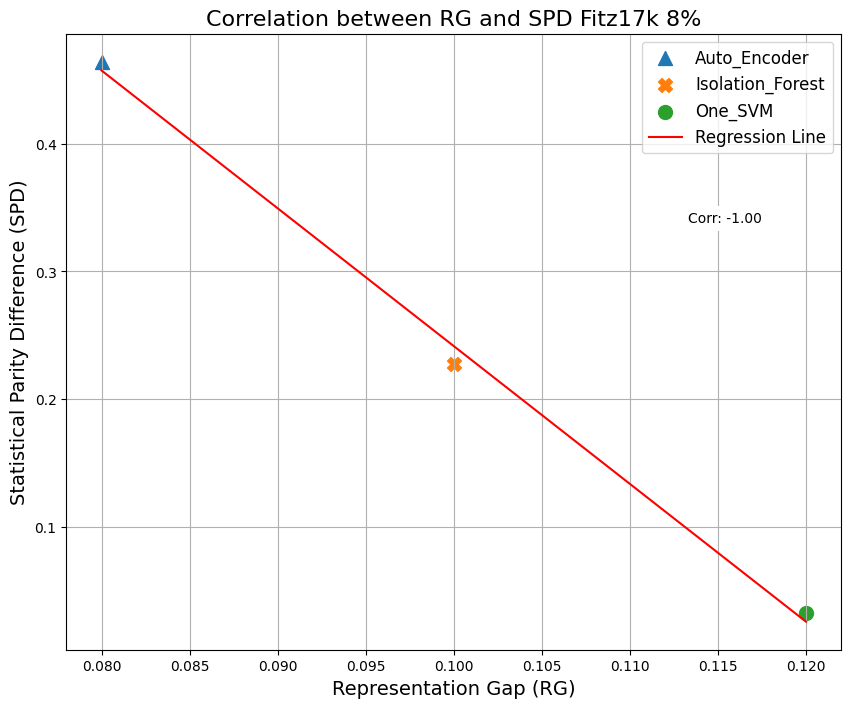

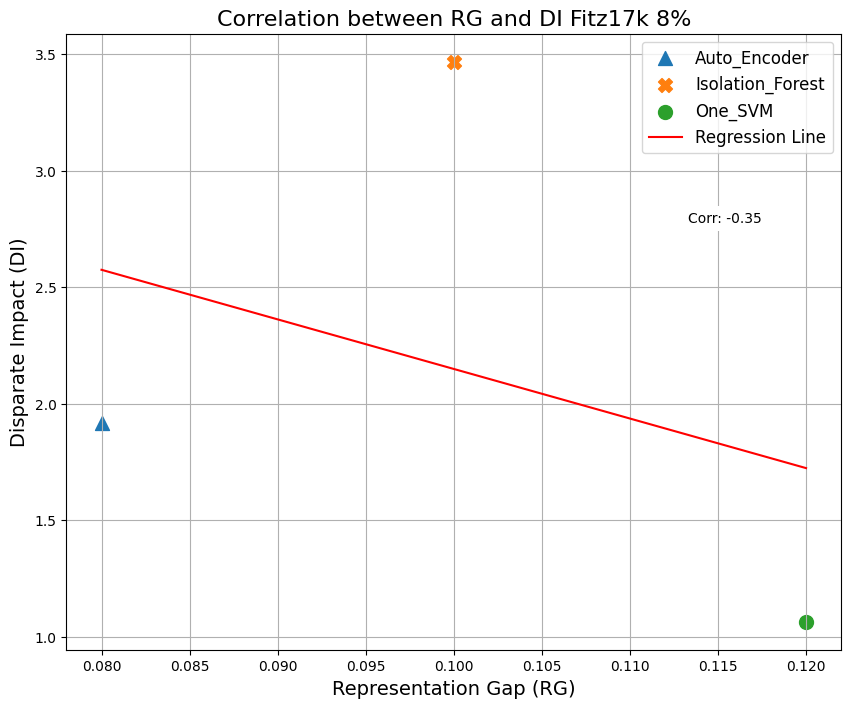

In [ ]:
# Extract data for plotting
x = df8['SPD'].values
y = df8['DI'].values
labels = df8['Model'].values
p='8'

Scatter_Plot(df8['SPD'], df8['DI'],labels,x_label='Statistical Parity Difference'  ,y_label='Disparate Impact',X='SPD',Y='DI',P=p)
Scatter_Plot(df8['RG'], df8['SPD'],labels,x_label='Representation Gap',y_label='Statistical Parity Difference',X='RG',Y='SPD',P=p)
Scatter_Plot(df8['RG'], df8['DI'],labels,x_label='Representation Gap',y_label='Disparate Impact',X='RG',Y='DI',P=p)


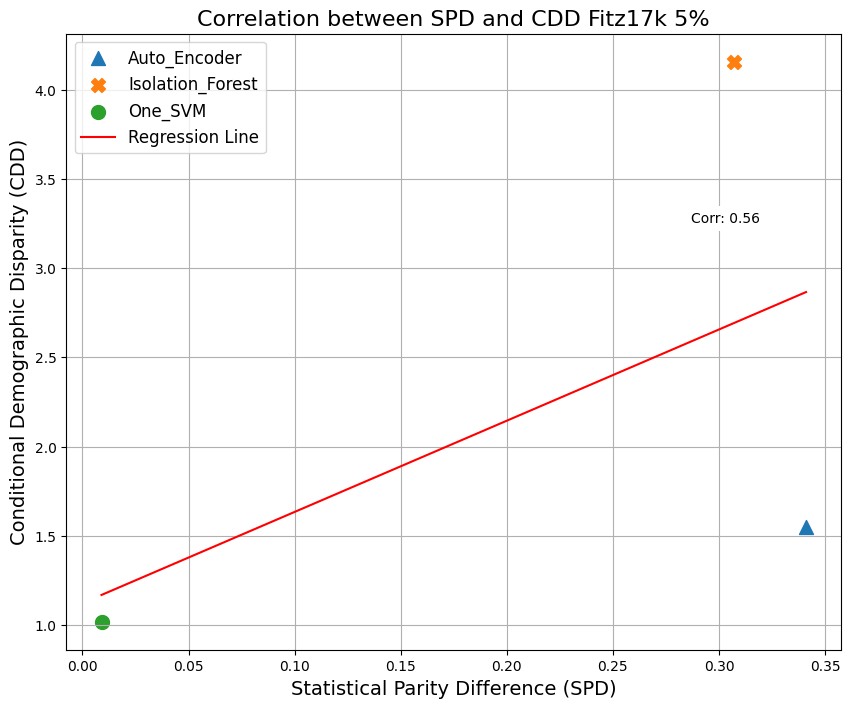

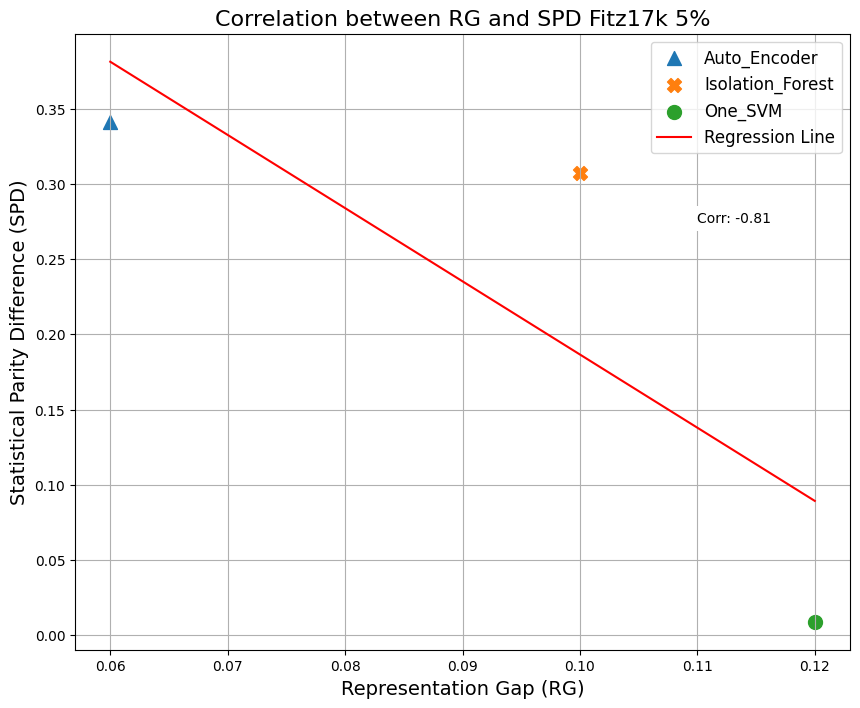

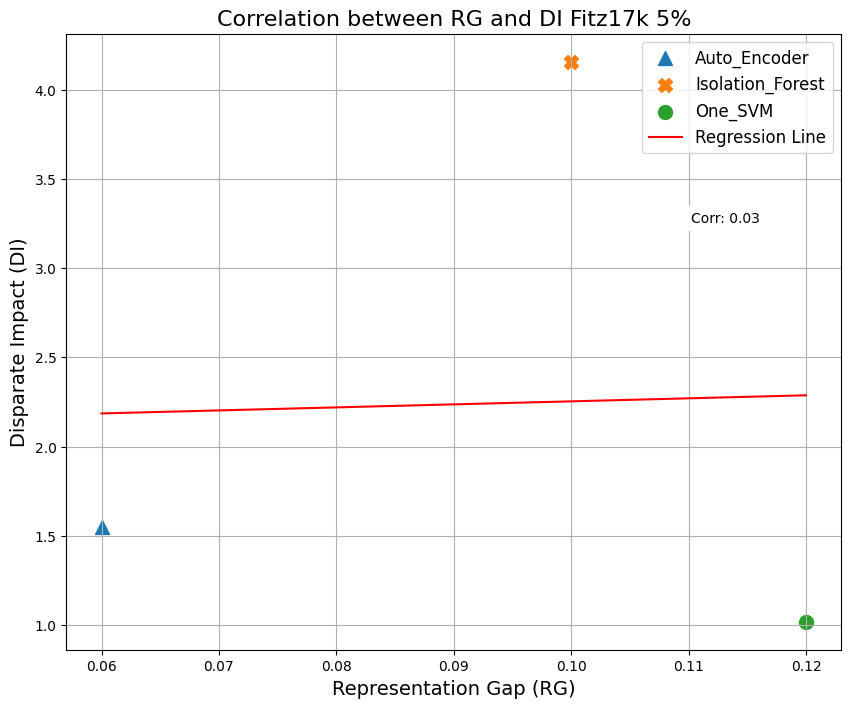

In [ ]:
# Extract data for plotting
x = df5['SPD'].values
y = df5['DI'].values
labels = df5['Model'].values
p='5'

Scatter_Plot(df5['SPD'], df5['DI'],labels,x_label='Statistical Parity Difference'  ,y_label='Disparate Impact',X='SPD',Y='CDD',P=p)
Scatter_Plot(df5['RG'], df5['SPD'],labels,x_label='Representation Gap',y_label='Statistical Parity Difference',X='RG',Y='SPD',P=p)
Scatter_Plot(df5['RG'], df5['DI'],labels,x_label='Representation Gap',y_label='Disparate Impact',X='RG',Y='DI',P=p)
